In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import numpy as np
import random
import pingouin as pg 

plt.rcParams["figure.figsize"] = (15,10)
sns.set_context('talk',font_scale=2)
plt.rcParams["lines.linewidth"] = 3
plt.rcParams['font.family'] = 'Verdana'
plot = False

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Single patch environment

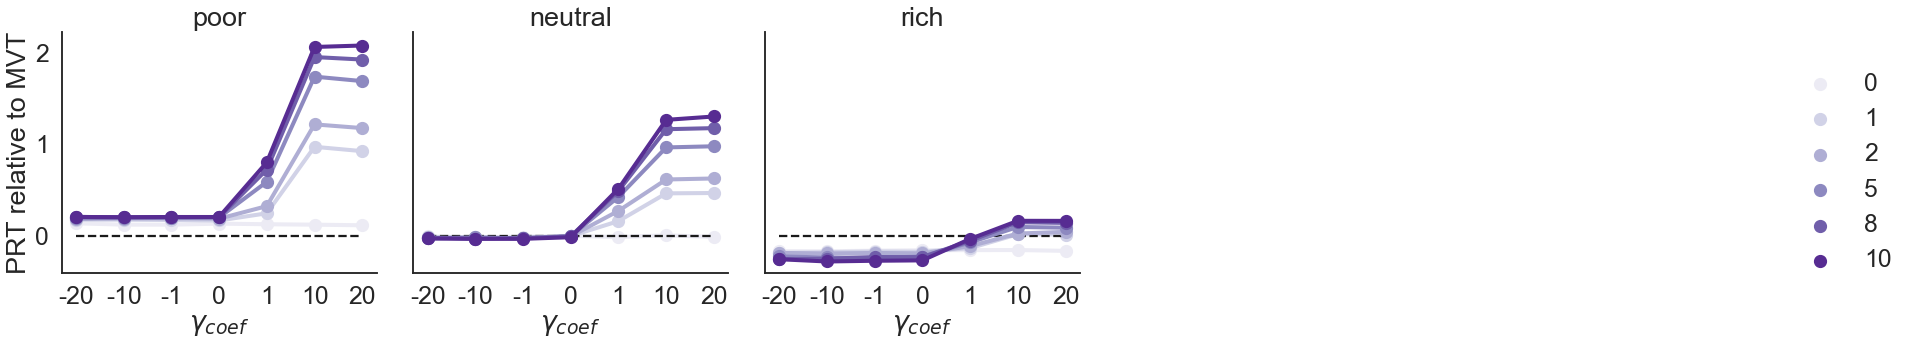

In [11]:
overharvest_df = pd.read_csv("model_results/single_patch_parameter_exploration_20221226.csv")

def make_plot(data,*args, **kwargs):
    sns.pointplot(x='gamma_coef',y='diff',palette='Purples',ci=68,hue='alpha',data=data)
    plt.plot([0,6],[0,0],'k--')
sns.set_theme(style="white")

plt.rcParams["figure.figsize"] = (20,10)
sns.set_context('talk',font_scale=1.5)

g = sns.FacetGrid(col='galaxy', data=overharvest_df,height=5,col_wrap=5,margin_titles=True)
g.map_dataframe(make_plot)
g.add_legend()
g.set_ylabels("PRT relative to MVT")
g.set_xlabels(r'$\gamma_{coef}$')
g.axes[0].set_title('poor')
g.axes[1].set_title('neutral')
g.axes[2].set_title('rich')
plot=True
if plot:
    plt.savefig('plots/parameter_exploration.png',bbox_inches = "tight",dpi=300)

## Three patch environment

In [89]:
import scipy.ndimage as sp

def prediction_heatmap(df):
    y=stats.norm(loc=df.loc[0].pred_decay,scale=np.sqrt(df.loc[0].uncertainty)).rvs(size=1000)
    x=np.ones((1000,))*0
    for i in range(1,np.shape(df)[0]):
        x=np.concatenate((x,np.ones((1000,))*i),axis=0)
        y=np.concatenate((y,stats.norm(loc=df.loc[i].pred_decay,scale=np.sqrt(df.loc[i].uncertainty)).rvs(size=1000)),axis=0)
    
    X = sp.filters.gaussian_filter(x, sigma = 2, order = 0)
    Y = sp.filters.gaussian_filter(y, sigma = 2, order = 0)
    
    heatmap, xedges, yedges = np.histogram2d(X, Y, bins=40)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    
    plt.hist2d(X,Y,bins=[np.shape(df)[0],100],vmin=0,vmax=200)

    plt.ylim([0.1,0.9])
    plt.colorbar()

    for index, row in df.iterrows():
        galaxy = row.galaxy
        true_decay = row.true_decay
        if galaxy==0:
            plt.plot([index],0.2,'x',color='white',markersize=15, mew=2)
        elif galaxy == 1:
            plt.plot([index],0.5,'x',color='white',markersize=15, mew=2)
        else:
            plt.plot([index],0.8,'x',color='white',markersize=15, mew=2)

    plt.ylabel("predicted decay")
    plt.xlabel("planet #")
    return 


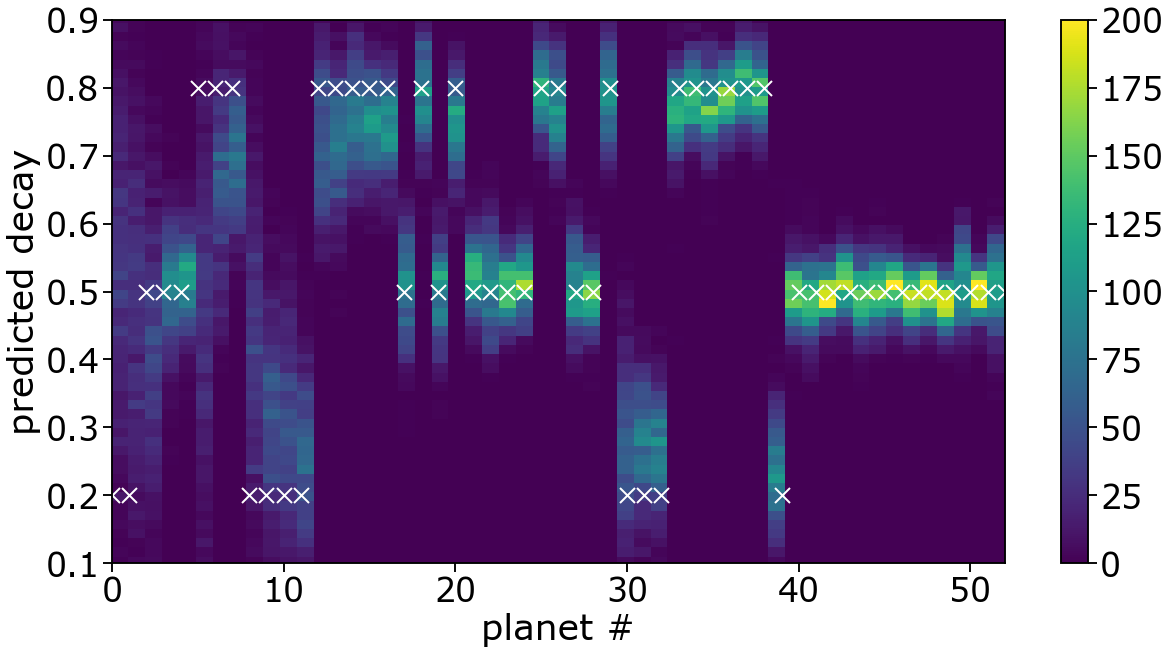

In [106]:
plt.rcParams["figure.figsize"] = (20,10)
df_alpha_1 = pd.read_csv("model_results/show_inference_1.csv")
prediction_heatmap(df_alpha_1)

if plot:
    plt.savefig('plots/decay_inference_trimodal_1_heatmap.png',bbox_inches = "tight",dpi=300)

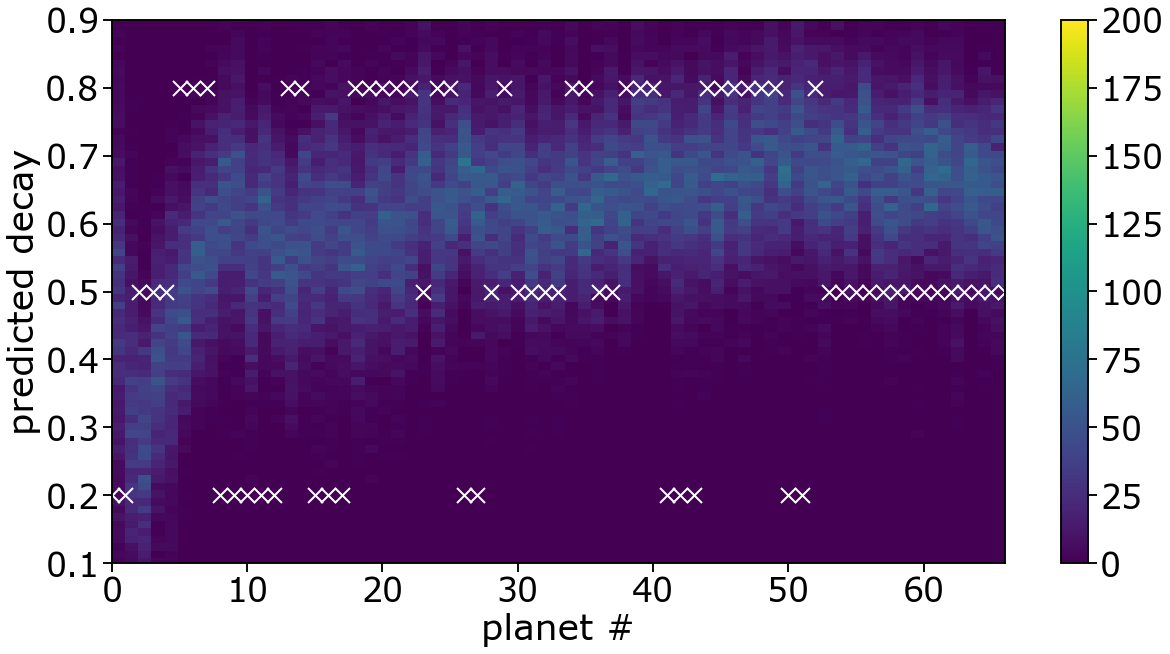

In [107]:
df_alpha_0 = pd.read_csv("model_results/show_inference_0.csv")
prediction_heatmap(df_alpha_0)

if plot:
    plt.savefig('plots/decay_inference_unimodal_0_heatmap.png',bbox_inches = "tight",dpi=300)

In [7]:
# load in simulations 
gamma_df = pd.DataFrame()
for gamma_coef in [1.0,0.5,0.2,0.1,0.0]:
    coef = str(gamma_coef).split(".")
    g = pd.read_csv("model_results/show_gamma_effective_2_2_"+coef[0]+coef[1]+".csv").reset_index()
    g['coef'] = gamma_coef
    gamma_df = pd.concat([gamma_df,g])


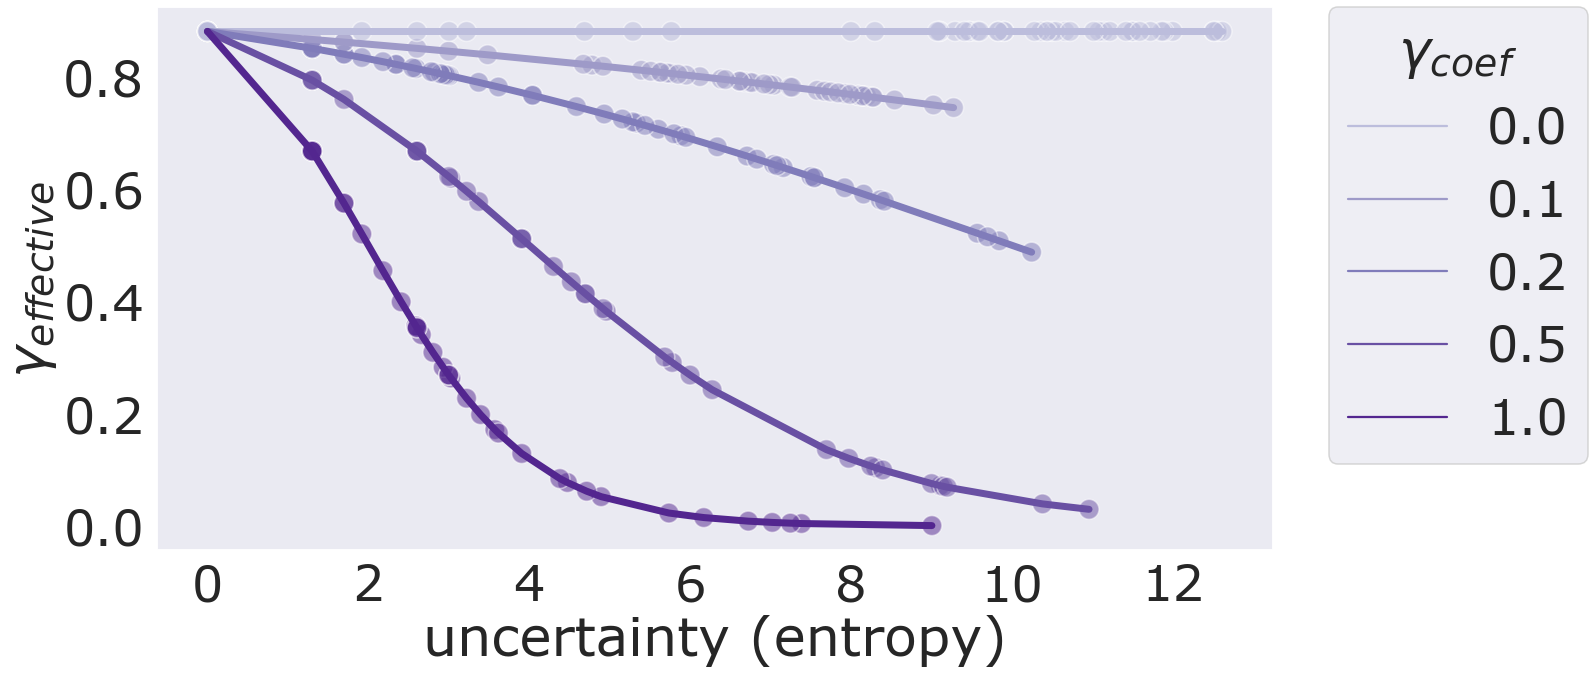

In [47]:
cm=sns.color_palette("Purples",7)
plt.rcParams["figure.figsize"] = (20,10)
sns.set_context('talk',font_scale=3.0)

a=sns.lineplot(
    data=gamma_df,
    x="entropy", y="gamma_effective",
    hue="coef",palette=cm[2:],linewidth=7)
b=sns.scatterplot(
    data=gamma_df,
    x="entropy", y="gamma_effective",
    hue="coef",palette=cm[2:],s=400,alpha=0.5,)
a.set_xlabel("uncertainty (entropy)")
a.set_ylabel(r'$\gamma_{effective}$')
h,l = a.get_legend_handles_labels()
plt.legend(h[0:5],l[0:5],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title=r'$\gamma_{coef}$')
if plot:
    plt.savefig('plots/gamma_eff_entropy.png',bbox_inches = "tight",dpi=300)

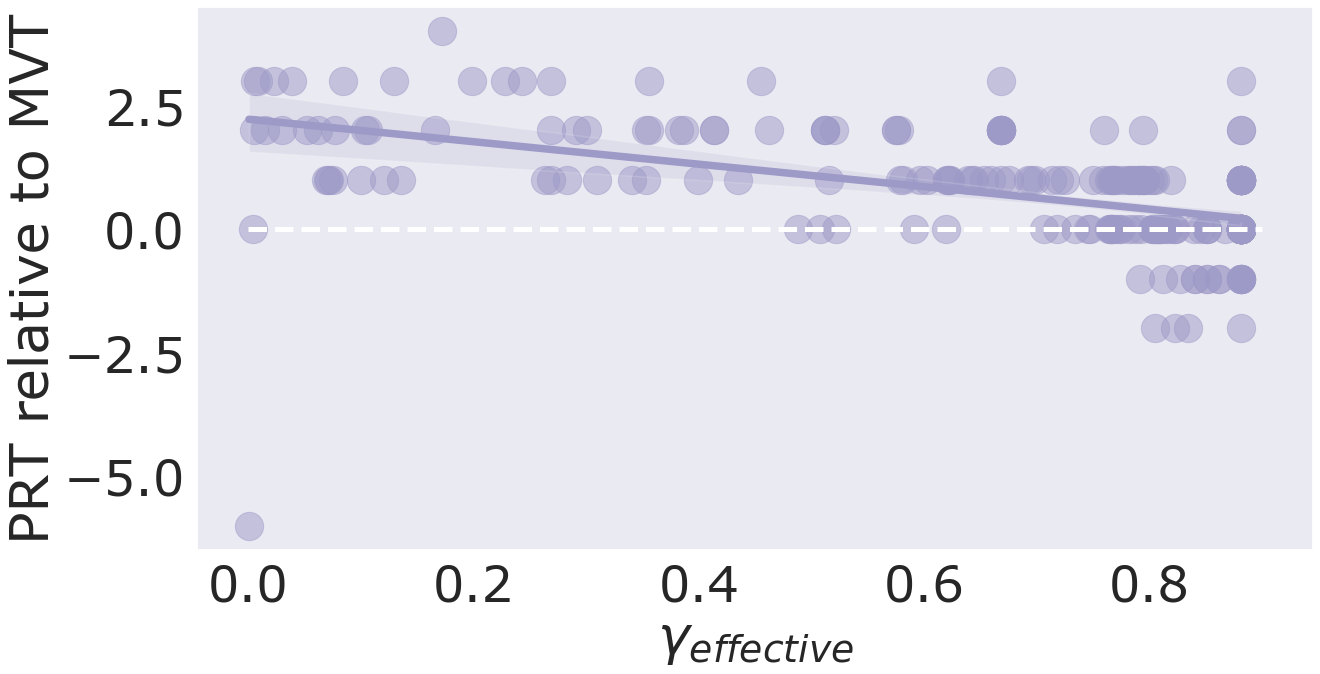

In [50]:
non_zero=gamma_df.query("coef>0")
cmap=sns.color_palette('twilight_shifted', as_cmap=True)
sns.set_theme(style="dark")
plt.rcParams['font.family'] = 'Verdana'
sns.set_context('talk',font_scale=3.0)

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["lines.linewidth"] = 5

sns.regplot(data=non_zero,x="gamma_effective",y="diff",scatter_kws={'s':800,'alpha':0.5},color=cm[3])
plt.plot([0,0.9],[0,0],'w--')


plt.ylabel("PRT relative to MVT")
plt.xlabel(r'$\gamma_{effective}$')
if plot:
    plt.savefig('plots/gamma_eff_overharvest.png',bbox_inches = "tight",dpi=300)

# Model fitting results

In [10]:
ad_discount = pd.read_csv("model_results/prt_val_adaptive_discount_10_10_3.csv")
ad_discount_params = pd.read_csv("model_results/params_val_adaptive_discount_10_10_3.csv")
ad_discount = ad_discount.rename(columns={"diff_mean":"prt_rel_om"})
#prt=prt.groupby(by=["sub_num","galaxy"]).mean().reset_index()
ad_discount['model'] = 'adaptive discount'

mvt = pd.read_csv("model_results/prt_val_MVT_learn.csv")
mvt_params = pd.read_csv("model_results/params_val_MVT_learn.csv")
mvt = mvt.rename(columns={"diff_mean":"prt_rel_om"})
mvt=mvt.groupby(by=["sub_num","galaxy"]).mean().reset_index()
mvt['model'] = 'MVT learn'

td = pd.read_csv("model_results/prt_val_TD.csv")
td_params = pd.read_csv("model_results/params_val_TD.csv")
td = td.rename(columns={"diff_mean":"prt_rel_om"})
td=td.groupby(by=["sub_num","galaxy"]).mean().reset_index()
td['model'] = 'TD'

data =pd.read_csv("data/ref_point_galaxy_dataset_2022_newOpt.csv")
data = data.groupby(by=["sub_num","galaxy"]).mean().reset_index()
data['model'] = 'data'

all_prt = pd.concat([ad_discount,mvt,td,data])
avg = all_prt.groupby(["sub_num","model","galaxy"]).mean().reset_index()


## model comparison

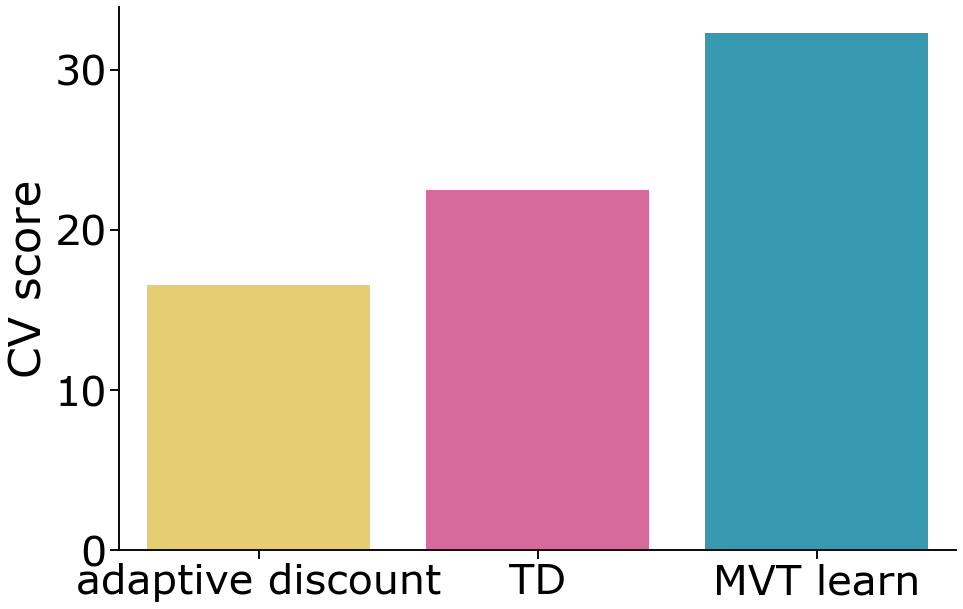

In [5]:
cv=pd.read_csv("model_results/cv_comp.csv")
plt.rcParams["figure.figsize"] = (15,10)
sns.set_context('talk',font_scale=2.5)
palette=["#FFDB58","#ed539b","#1ca9c9",]
g=sns.barplot(x='model',y='cv',ci=None,estimator=np.mean,saturation=0.7,palette=palette,data=cv)

plt.ylabel("CV score")
plt.xticks([0,1,2],['adaptive discount','TD','MVT learn'])
plt.xlabel("")
sns.despine(right=True)
if plot:
    plt.savefig('plots/cv.png',bbox_inches = "tight",dpi=300)

## model validation

In [27]:
ad_discount=pd.read_csv("model_results/overharvest_adapt_adaptive_discount_10_10_3.csv").query("n_sim==1")
ad_discount['model']='adaptive discount'
ad_discount = ad_discount.rename(columns={"diff":"prt_rel_om"})

td = pd.read_csv("model_results/overharvest_adapt_TD.csv").query("n_sim==1")
td['model']='TD'
td = td.rename(columns={"diff":"prt_rel_om"})


mvt = pd.read_csv("model_results/overharvest_adapt_MVT.csv").query("n_sim==1")
mvt['model']='MVT learn'
mvt = mvt.rename(columns={"diff":"prt_rel_om"})

all_prt_full = pd.concat([ad_discount,mvt,td,data])

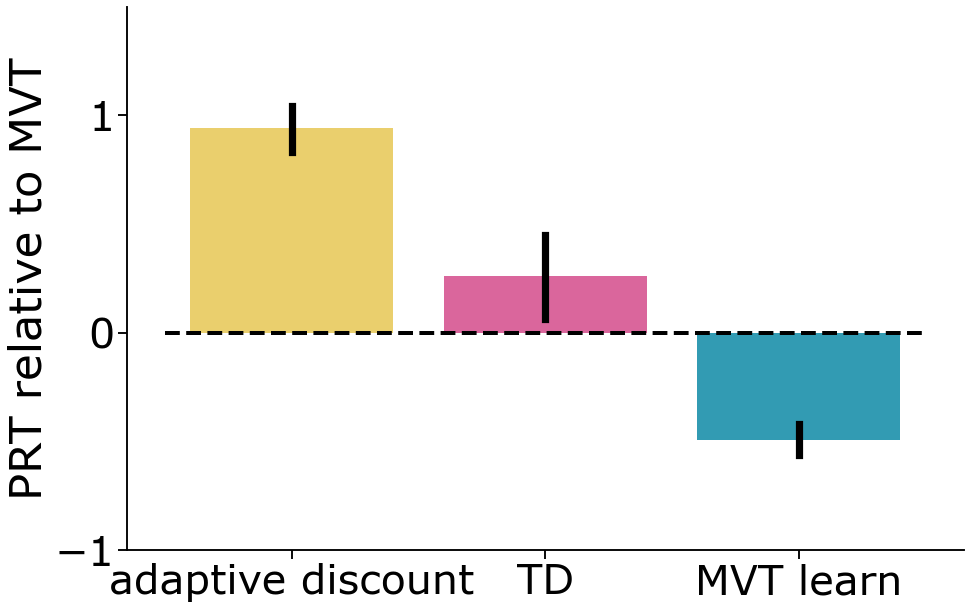

In [38]:
plt.rcParams["figure.figsize"] = (15,10)
sns.set_context('talk',font_scale=2.5)
plt.rcParams["lines.linewidth"] = 4
palette=["#FFDB58","#ed539b","#1ca9c9",]


avg=all_prt_full.query("model!='data'").groupby(['sub_num','model']).mean().reset_index()
g=sns.barplot(x='model',y='prt_rel_om',order = ['adaptive discount','TD','MVT learn'],ci=68,palette=palette,data=avg)
    
for i,patch in enumerate(g.lines):
    patch.set_color('black')


g.set_ylabel("PRT relative to MVT")
plt.xticks([0,1,2],['adaptive discount','TD','MVT learn'])
plt.plot([-0.5,2.5],[0,0],'k--')
plt.ylim([-1,1.5])
plt.yticks([-1,0,1])
g.set_xlabel("")
sns.despine(right=True)
plot=True
if plot:
    plt.savefig("plots/model_fit.png",bbox_inches = "tight",dpi=300)

In [35]:
stats.ttest_1samp(avg.query("model=='adaptive discount'").prt_rel_om,popmean=0)

Ttest_1sampResult(statistic=8.86606410009423, pvalue=1.130464041283876e-14)

In [36]:
stats.ttest_1samp(avg.query("model=='TD'").prt_rel_om,popmean=0)

Ttest_1sampResult(statistic=1.3049427729231626, pvalue=0.19451748530836596)

In [37]:
stats.ttest_1samp(avg.query("model=='MVT learn'").prt_rel_om,popmean=0)

Ttest_1sampResult(statistic=-7.2554942621791785, pvalue=5.040665988896794e-11)

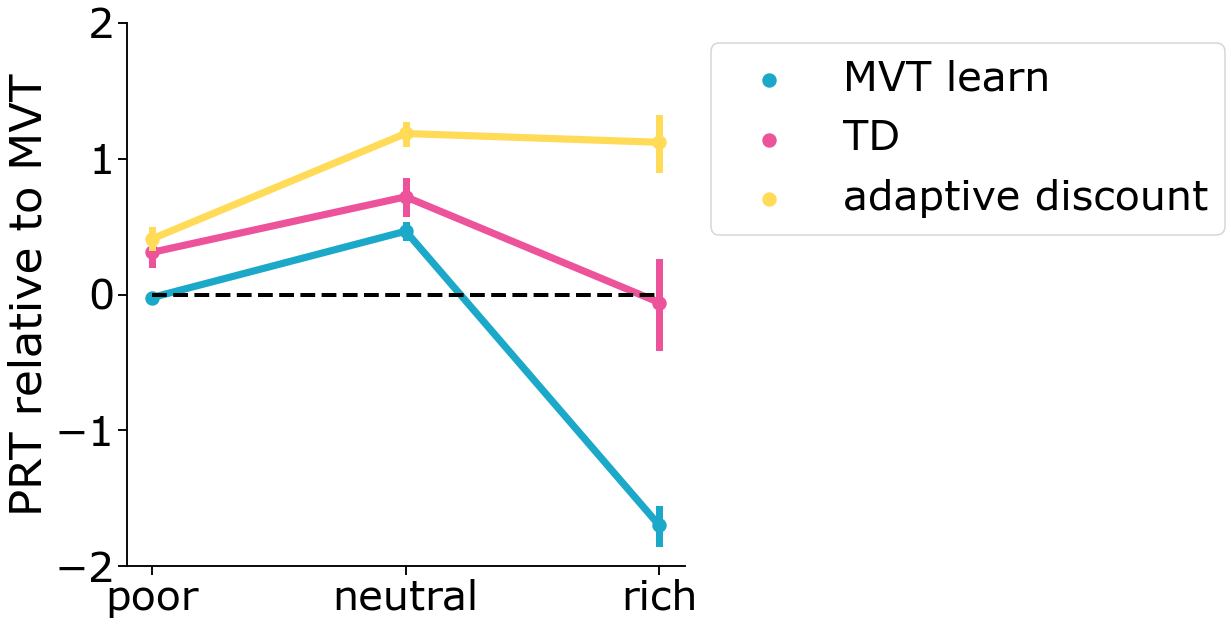

In [11]:
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context('talk',font_scale=2.5)
plt.rcParams["lines.linewidth"] = 4
palette=["#1ca9c9","#ed539b","#FFDB58"]

avg=all_prt.query("model!='data'").groupby(['sub_num','model','galaxy']).mean().reset_index()
g=sns.pointplot(x='galaxy',y='prt_rel_om',hue='model',ci=68,saturation=0.7,palette=palette,linewidth=4,markers='.',errwidth=7,data=avg)
g.set_ylabel("PRT relative to MVT")
plt.xticks([0,1,2],['poor','neutral','rich'])
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
plt.plot([0,2],[0,0],'k--')
plt.ylim([-2,2])
plt.yticks([-2,-1,0,1,2])
g.set_xlabel("")
sns.despine(right=True)
plot=False
if plot:
    plt.savefig("plots/model_validation.png",bbox_inches = "tight",dpi=300)

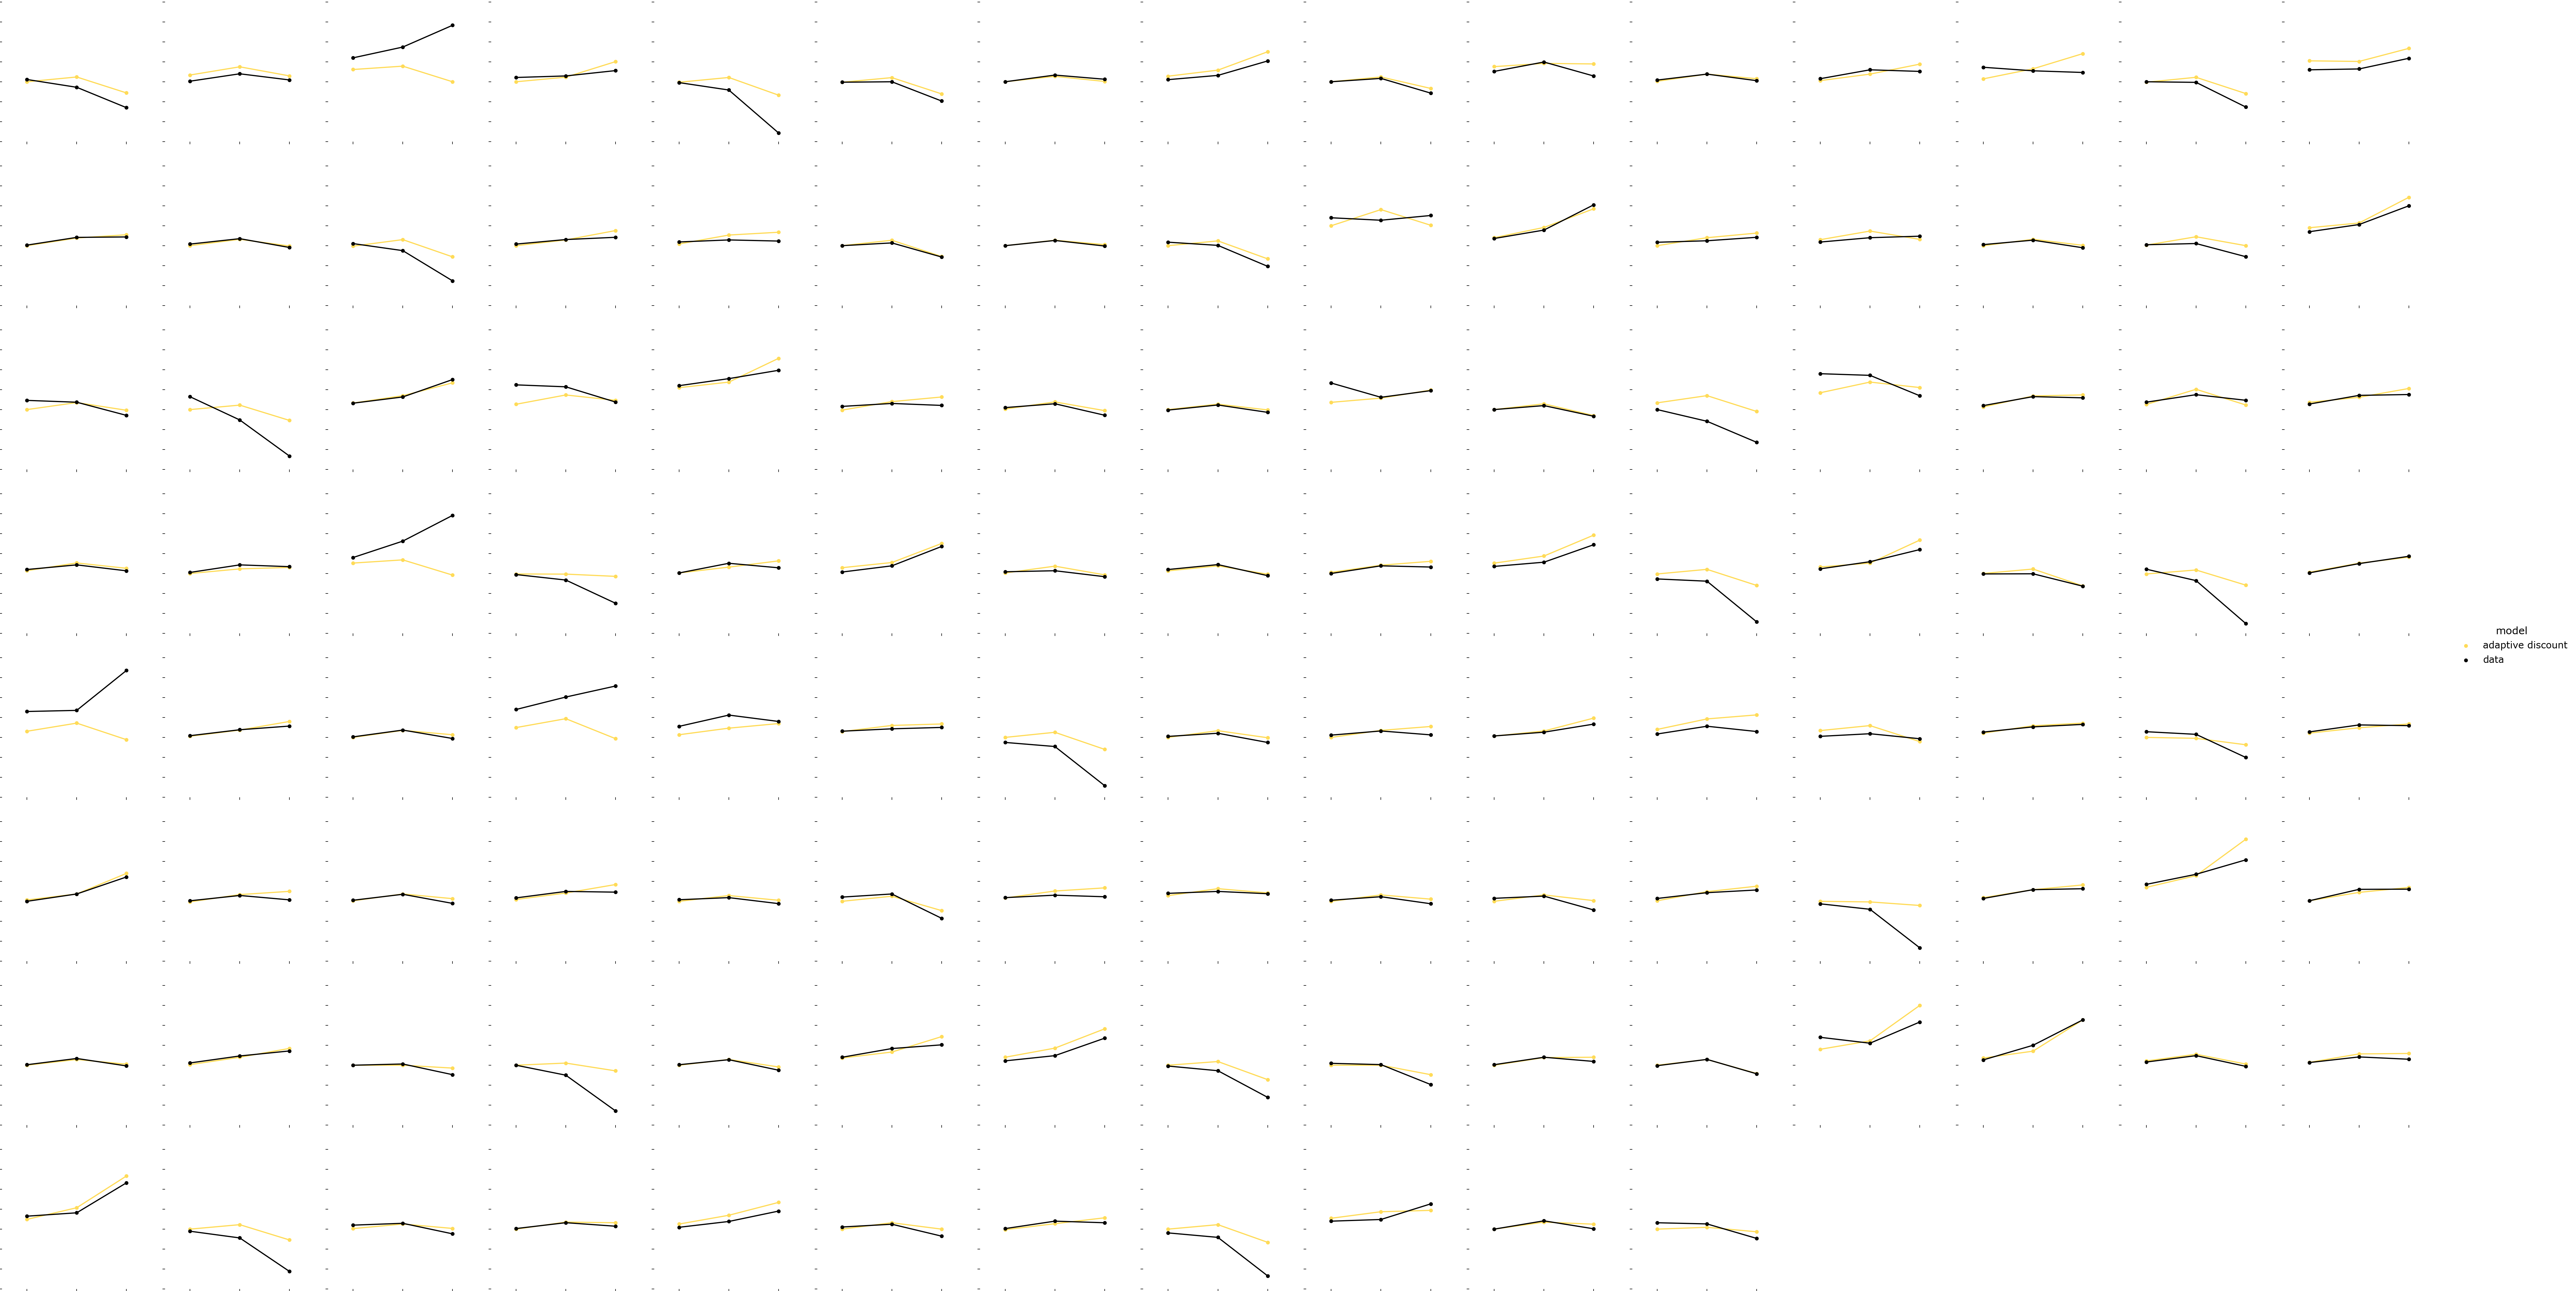

In [11]:
# INDIVIDUAL SUBJECTS 
g = sns.catplot(x="galaxy",y="prt_rel_om",col='sub_num',data=all_prt.query("model !='TD' & model !='MVT learn'"),hue="model", kind="point",height=8,palette=[palette[2],"black"],col_wrap=15,margin_titles=True)
g.despine(top=True,left=True,right=True,bottom=True)
g.set_titles("")
g.set_ylabels("")
g.set_xlabels("")
g.set_xticklabels([])
g.set_yticklabels([])

if plot:
    plt.savefig('plots/model_compare_data_indivual_sub_adaptive_discount.png',dpi=150,bbox_inches = "tight")

# parameter distributions

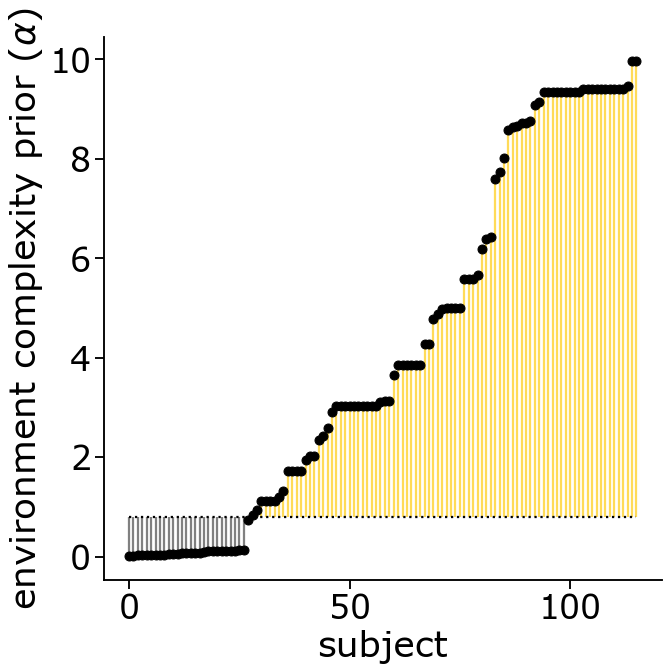

In [12]:
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context('talk',font_scale=2)
my_pal =["grey"]*28 + [palette[2]]*88

avg = ad_discount_params.groupby(by="sub_num").mean().reset_index()#.query("sub_num not in @to_drop")
unsort_avg = pd.melt(avg,id_vars=['sub_num'],value_vars=['alpha'],var_name='param',value_name='value')
sort_avg=unsort_avg.sort_values(by='value').value.to_list()
subject = list(range(len(avg.sub_num)))

markerline, stemlines, baseline=plt.stem(subject, sort_avg, markerfmt = 'ro', linefmt='r-', basefmt = 'r:', bottom=0.8,use_line_collection=True)
plt.setp(stemlines, 'color', my_pal)#pal[3]
plt.setp(markerline, 'color', 'k')
plt.setp(baseline, 'color', 'k')
plt.ylabel(r'environment complexity prior ($\alpha$)')
plt.xlabel("subject")
sns.despine(right=True)
if plot:
    plt.savefig('plots/alpha.png',bbox_inches = "tight",dpi=300)

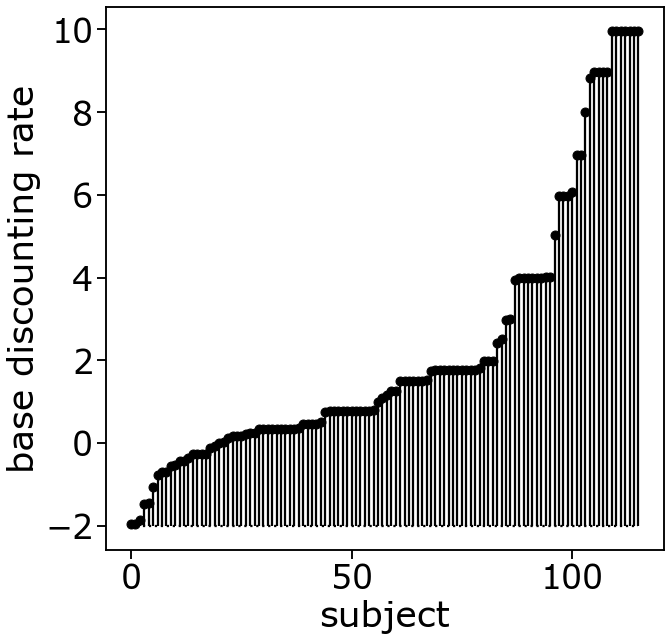

In [13]:
avg = ad_discount_params.groupby(by="sub_num").mean().reset_index()
unsort_avg = pd.melt(avg,id_vars=['sub_num'],value_vars=['gamma_base'],var_name='param',value_name='value')
sort_avg=unsort_avg.sort_values(by='value').value.to_list()
subject = list(range(len(avg.sub_num)))

markerline, stemlines, baseline=plt.stem(subject, sort_avg, markerfmt = 'ro', linefmt='r-', basefmt = 'r:', bottom=-2,use_line_collection=True)
plt.setp(stemlines, 'color', 'k')#pal[3]
plt.setp(markerline, 'color', 'k')
plt.setp(baseline, 'color', 'k')
plt.ylabel('base discounting rate')
plt.xlabel("subject")
if plot:
    plt.savefig('plots/gamma_base.png',bbox_inches = "tight",dpi=300)

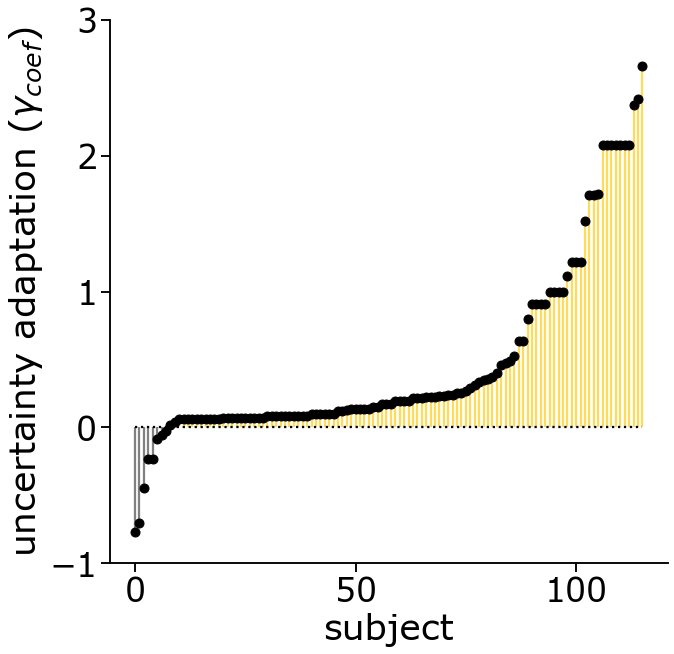

In [14]:
plt.rcParams["figure.figsize"] = (10,10)
my_pal =["grey"]*8 + [palette[2]]*108
avg = ad_discount_params.groupby(by="sub_num").mean().reset_index()
unsort_avg = pd.melt(avg,id_vars=['sub_num'],value_vars=['gamma_coef'],var_name='param',value_name='value')
sort_avg=unsort_avg.sort_values(by='value').value.to_list()
subject = list(range(len(avg.sub_num)))

markerline, stemlines, baseline=plt.stem(subject, sort_avg, markerfmt = 'ro', linefmt='r-', basefmt = 'r:', bottom=0,use_line_collection=True)
plt.setp(stemlines, 'color', my_pal)#pal[3]
plt.setp(markerline, 'color', 'k')
plt.setp(baseline, 'color', 'k')
plt.ylabel(r'uncertainty adaptation ($\gamma_{coef}$)')
plt.xlabel("subject")
plt.ylim([-1,3])
plt.yticks([-1,0,1,2,3])
sns.despine(right=True)

if plot:
    plt.savefig('plots/gamma_coef.png',bbox_inches = "tight",dpi=300)

## untransform parameters from bounds to be normally distributed

In [15]:
ad_discount_params['alphaz']=-np.log(-1 + (10/np.array(ad_discount_params['alpha'])))
ad_discount_params['gamma_basez']=-np.log(-1 + ((12)/(np.array(ad_discount_params['gamma_base']+2))))
ad_discount_params['gamma_coefz']=-np.log(-1 + (6/(np.array(ad_discount_params['gamma_coef']+3))))
ad_discount_params.to_csv("model_results/untransformed_params_2022.csv")

# Supplemental Results

## compare TD and adaptive discounting - divergent predictions

In [4]:
def label_switch(row):
    if row['n_galaxy'] ==1:
        return 'switch'
    else:
        return 'no_switch'

In [5]:
ad_discount = pd.read_csv("model_results/overharvest_adapt_adaptive_discount_10_10_3.csv")
td = pd.read_csv("model_results/overharvest_adapt_TD.csv")

subs = np.unique(ad_discount.sub_num)

ad_discount["switch"] = ad_discount.apply (lambda row: label_switch(row), axis=1)
td["switch"] = td.apply (lambda row: label_switch(row), axis=1)

ad_discount = ad_discount.query("galaxy !=2&block<4").groupby(by=["sub_num","switch","n_sim"]).mean().reset_index()
td = td.query("galaxy !=2&block<4").groupby(by=["sub_num","switch","n_sim"]).mean().reset_index()

ad_discount_overharvest = pd.DataFrame()

for sub in subs:
    for n in range(1,51):
        no_sw = ad_discount.query("sub_num==@sub & n_sim==@n & switch=='no_switch'")['diff'].values
        sw = ad_discount.query("sub_num==@sub & n_sim==@n & switch=='switch'")['diff'].values
        diff = (sw-no_sw)[0]
        
        ad_discount_overharvest = pd.concat([ad_discount_overharvest, pd.DataFrame({'sub_num':sub,'n_sim':n,'diff':diff},index=[0])])

td_overharvest = pd.DataFrame()

for sub in subs:
    for n in range(1,51):
        no_sw = td.query("sub_num==@sub & n_sim==@n & switch=='no_switch'")['diff'].values
        sw = td.query("sub_num==@sub & n_sim==@n & switch=='switch'")['diff'].values
        diff = (sw-no_sw)[0]
        
        td_overharvest = pd.concat([td_overharvest, pd.DataFrame({'sub_num':sub,'n_sim':n,'diff':diff},index=[0])])        

data_overharvest = pd.read_csv("data/overharvesting_switch_noSwitch.csv")

In [6]:
ad_discount_overharvest = ad_discount_overharvest.groupby(by=["sub_num"]).mean().reset_index()
td_overharvest = td_overharvest.groupby(by=["sub_num"]).mean().reset_index()


In [7]:
stats.ttest_1samp(ad_discount_overharvest['diff'],popmean=0)

Ttest_1sampResult(statistic=8.634495412169004, pvalue=3.8738200625625064e-14)

In [8]:
stats.ttest_1samp(td_overharvest['diff'],popmean=0)

Ttest_1sampResult(statistic=3.106242900165579, pvalue=0.0023868705270999)

In [10]:
stats.ttest_ind(ad_discount_overharvest['diff'],td_overharvest['diff'])

Ttest_indResult(statistic=2.0035986431114945, pvalue=0.0462862472730444)

In [14]:
n_sub = len(td_overharvest)
all_overharvest = pd.DataFrame({'sub_num':list(np.unique(ad_discount_overharvest.sub_num))+list(np.unique(ad_discount_overharvest.sub_num)) + list(data_overharvest.sub_num),
                                'model':['adaptive_discount']*n_sub + ['td']*n_sub +['data']*len(data_overharvest.sub_num),'diff':list(ad_discount_overharvest['diff'])+list(td_overharvest['diff'])+list(data_overharvest['diff'])})


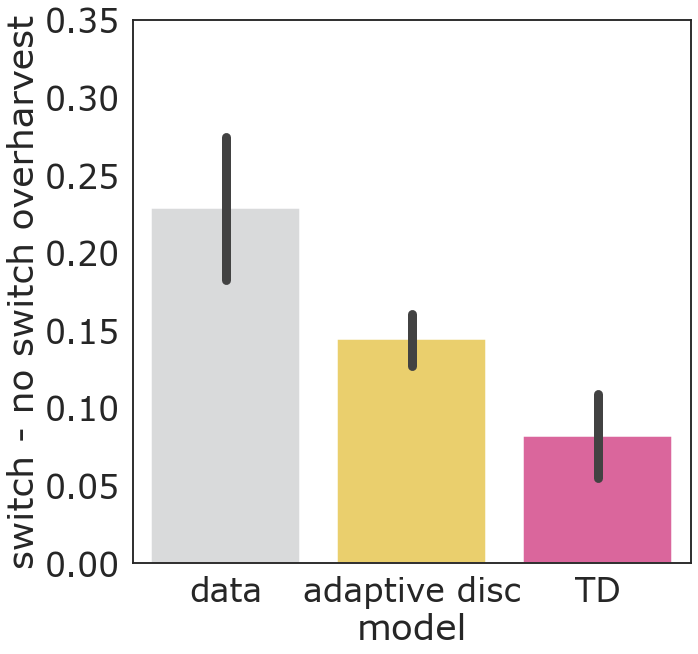

In [31]:
import matplotlib as mpl
palette=["#d9dadb","#FFDB58","#ed539b"]
sns.set_theme(style="white")
plt.rcParams['font.family'] = 'Verdana'
sns.set_context('talk',font_scale=2.0)

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["lines.linewidth"] = 5


g=sns.barplot(x="model",y="diff",order=['data','adaptive_discount','td'],palette=palette,ci=68,data=all_overharvest)
g.set_ylabel("switch - no switch overharvest")
g.set_xlabel("model")
g.set_xticklabels(['data','adaptive disc','TD'],)
g.set_ylim([0,0.35])
if plot:
    plt.savefig('plots/td_v_adaptive_discount_switch_explicit.png',bbox_inches = "tight",dpi=300)

In [11]:
stats.ttest_ind(list(ad_discount_overharvest['diff']),list(data_overharvest['diff']))

Ttest_indResult(statistic=-1.7091251614355425, pvalue=0.08877663225901668)

In [12]:
stats.ttest_ind(list(td_overharvest['diff']),list(data_overharvest['diff']))

Ttest_indResult(statistic=-2.7460150544271547, pvalue=0.0065095040427916)